Matrix Multiplication is defined as follows

$$R_{ij} = \sum_k A_{ik}B_{kj}$$


## Step 1

Derive a formula for how many basic operations are required for a matrix multiplication



### Solution

* there are $i\cdot j$ entries in the resulting matrix
* for each entry there are k terms we need to add to the result of this entry (1 addition) and to compute what to add we need to compute $A_{ik}B_{kj}$ (1 multiplication)
* $2k$ basic operations for each entry and $i\cdot j$ entries
* $2ijk$ operations per matrix multiplication

## Step 2
Implement an non-fancy algorithm (just use python loops) that multiplies to matrices and returns
  * The resulting matrix R
  * A count of the number of additions and multiplications (i.e. floating point operations) required for the computation

In [1]:
def matmul(A,B):
    Arows, Acols = A.shape
    Brows, Bcols = B.shape
    if not Acols == Brows:
        raise RuntimeError('nope!')
    result = np.zeros((Arows,Bcols))
    counter = 0
    for i in range(Arows):
        for j in range(Bcols):
            value = 0
            for k in range(Acols):
                value = value + (A[i,k] * B[k,j])
                counter += 2
            result[i,j] = value
    return result,counter

## Step 3
* Check that your code works by comparing the result with `np.matmul` using the function `np.allclose` and using random matrices (from a standard normal)
* Check your formula for the full number of floating point operations (FLOPS)

In [2]:
import numpy as np
A = np.random.normal(size = (10,50))
B = np.random.normal(size = (50,20))
R,c = matmul(A,B)
print(np.allclose(R,np.matmul(A,B)))
print(c,2*10*50*20)

True
20000 20000


## Step 4

Consider this decreasing set of matrices
* A = Matrix with shape (100,200)
* B = Matrix with shape (50,100)
* C = Matrix with shape (2,50)

We are interested in computing $M = ABC$ and we could do it 2 ways

* The "forward" way $C(BA)$
* The "backward" way $(CB)A$

* Use your matrix multiply to compute the computational cost of these two options
* cross-check with your formula that this matches expectations
* Which one is more advantagous for a linear map from 200 → 2 dimensions? What's the ratio of the reuqired FLOPs?

In [3]:
A = np.random.uniform(size = (100,200))
B = np.random.uniform(size = (50,100))
C = np.random.uniform(size = (2,50))

R,c1 = matmul(B,A)
R,c2 = matmul(C,R)
fwd_cost = c1+c2
print(fwd_cost, (2*50*200*100) + (2*2*50*200))


R,c1 = matmul(C,B)
R,c2 = matmul(R,A)
rev_cost = c1+c2
print(rev_cost, (2*100*2*50) + (2*2*100*200))

ratio = fwd_cost/rev_cost
print(ratio)

2040000 2040000
100000 100000
20.4


## Step 5

Repeat the same Exercise for an increasing set of matrices


* A = Matrix with shape (300,2)
* B = Matrix with shape (500,300)
* C = Matrix with shape (1000,500)

Which direction is more advantages now?

In [4]:
A = np.random.uniform(size = (300,2))
B = np.random.uniform(size = (500,300))
C = np.random.uniform(size = (1000,500))

R,c1 = matmul(B,A)
R,c2 = matmul(C,R)
fwd_cost = c1+c2
print(fwd_cost, (2*50*200*100) + (2*2*50*200))


R,c1 = matmul(C,B)
R,c2 = matmul(R,A)
rev_cost = c1+c2
print(rev_cost, (2*100*2*50) + (2*2*100*200))

ratio = rev_cost/fwd_cost
print(ratio)

2600000 2040000
301200000 100000
115.84615384615384


## Step 6

Take the function $$\mathbb{R}^3 \to \mathbb{R}^2$$

* Install the library JAX `pip install jax jaxlib`

and consider the following function

```python
import jax
import jax.numpy as jnp

def func(x):
    x1,x2,x3 = x
    z1 = 2*x1*x2
    z2 = x3**2
    return jnp.array([z1,z2])
```

* What is the Jacobian of this function $\frac{\partial z_i}{\partial x_i}$?
* What does the Jacobian look like at the input `X = [2.,3.,2.]` ?

$$J = \left(\begin{array}{}
  2x_2 & 2x_1 & 0\\
  0 & 0 & 2x_3\\
\end{array}\right)$$

At `x = [2.,3.,2.]`

$$J = \left(\begin{array}{}
  6 & 4 & 0\\
  0 & 0 & 4\\
\end{array}\right)$$


## Step 7

`jax` allows us to extract the Jacobian via Jacobian Vector Products of Vector Jacobian products

To compute $Jv$ at a point $x$ we can use `value, jac_column = jax.jvp(function, (x,), (v,))` 

This will give us `value` corresponding to $f(x)$ and `jac_column` corresponding to $Jv$

* Use this API to extract the 3 columns of the Jacobian via 3 special choices of $v$

In [5]:
import jax
import jax.numpy as jnp

def func(X):
    a,b,c = X
    z1 = 2*a*b
    z2 = b**2
    return jnp.array([z1,z2])

x = jnp.array([2.,3.,2.])
_,col1 = jax.jvp(func,(x,),(jnp.array([1.,0.,0.]),))
_,col2 = jax.jvp(func,(x,),(jnp.array([0.,1.,0.]),))
_,col3 = jax.jvp(func,(x,),(jnp.array([0.,0.,1.]),))

np.column_stack([col1,col2,col3])

array([[6., 4., 0.],
       [0., 6., 0.]], dtype=float32)

## Step 8

`jax` also allows us to to VJPs. As we know these are the ones that are most important for Deep Learning

Here the API is slighly different. We can call `value, vjp_func = jax.vjp(function,x)`
The variable `value` will correspond as usual to $f(x)$, while `jvp_func` is a function that we can call
with `vjp_func(v)` to compute $v^T J$

In [6]:
value, vjp_func = jax.vjp(func,x)
print(vjp_func(jnp.array([1.,0.])))
print(vjp_func(jnp.array([0.,1.])))

(DeviceArray([6., 4., 0.], dtype=float32),)
(DeviceArray([0., 6., 0.], dtype=float32),)


Congratulations - you've now used your first automatic differentiation system!

To celebrate let's calculate the gradient of some fun functions

In JAX we can do this like this

```python
def myfunction(x):
    return x**2


value_and_gradient_func = jax.vmap(jax.value_and_grad(myfunction))
```

`value_and_gradient_func` now is a function in which we an pass an array of x values and it will return an array
of y values and the gradient value $\frac{\partial f}{\partial x}$ at that point.

```python
values, gradients = value_and_gradient_func(xarray)
```

Use this to compute the function value and gradients for `x^2`, `\sin(x^2)\cos(x)`, or whatever function you can thing of on the interval (-5,5)

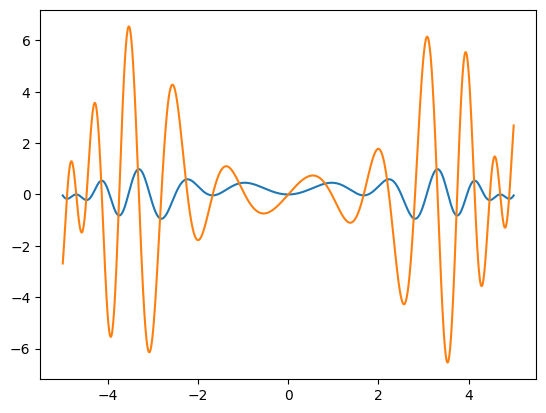

In [9]:
import matplotlib.pyplot as plt
def myfunction(x):
    return jnp.sin(x**2)*jnp.cos(x)

value_and_gradients = jax.vmap(jax.value_and_grad(myfunction))

xi = np.linspace(-5,5,1001)
yi,gi = value_and_gradients(xi)
plt.plot(xi,yi, label = 'func')
plt.plot(xi,gi, label = 'grad')